## Calories Burnt Prediction

### I. Introduction

Predicting the number of calories burned during physical activities is a significant challenge in health and fitness analytics. Calories burned depend on various factors, including demographic attributes like age, gender, and physiological characteristics, as well as exercise-specific parameters like duration, heart rate, and body temperature. By accurately predicting calories burned, we can provide valuable insights for personalized fitness planning, weight management, and health monitoring.

This project aims to develop a machine learning model to predict the number of calories burned based on demographic and exercise-related data. Two datasets, calories.csv and exercise.csv, are used. The calories.csv dataset provides the target variable, "Calories," while the exercise.csv dataset contains predictors such as Gender, Age, Height, Weight, Duration, Heart_Rate, and Body_Temp.

### II. Understanding the data

In [32]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# Load the datasets
calories_df = pd.read_csv("data/calories.csv")
exercise_df = pd.read_csv("data/exercise.csv")

# Merge the datasets on User_ID
df = pd.merge(exercise_df, calories_df, on="User_ID")

# Display dataset information
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [8]:
# Check for missing values
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [14]:
# Drop the User_ID column
df = df.drop(columns=["User_ID"])

In [15]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      15000 non-null  object 
 1   Age         15000 non-null  int64  
 2   Height      15000 non-null  float64
 3   Weight      15000 non-null  float64
 4   Duration    15000 non-null  float64
 5   Heart_Rate  15000 non-null  float64
 6   Body_Temp   15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.0+ MB


In [16]:
# Display basic statistics to understand the data distribution
df.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [27]:
# Convert Gender to a numeric variable using encoding (0 for female, 1 for male)
df['Gender'] = df['Gender'].map({'female': 0, 'male': 1})

# Rename the 'Gender' column to 'Male'
df.rename(columns={'Gender': 'Male'}, inplace=True)

# Confirm change
df.head()

,Male,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0


### III. EDA and Visualization

In this section, we analyze the dataset to understand the underlying patterns and relationships between variables. The EDA focuses on visualizing the distribution of each feature, identifying correlations, and exploring how the independent variables relate to the target variable, Calories. This step provides valuable insights that guide feature selection and model development for predicting calories burned.

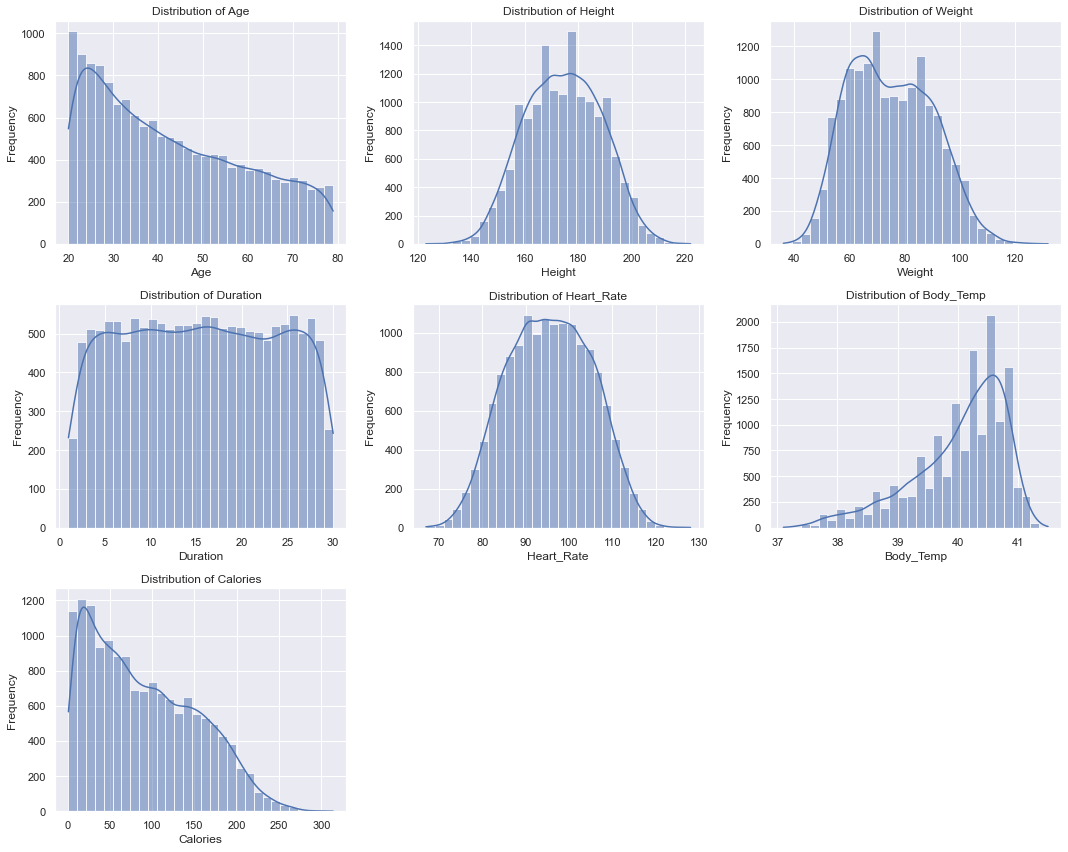

In [30]:
import math
sns.set()

# List of numerical columns
numerical_columns = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Determine the number of rows and columns for subplots
num_columns = len(numerical_columns)
num_rows = math.ceil(num_columns / 3)

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

# Flatten axes for easier indexing
axes = axes.flatten()

# Generate histograms for each column
for idx, column in enumerate(numerical_columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')
    
# Remove empty subplots if any
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

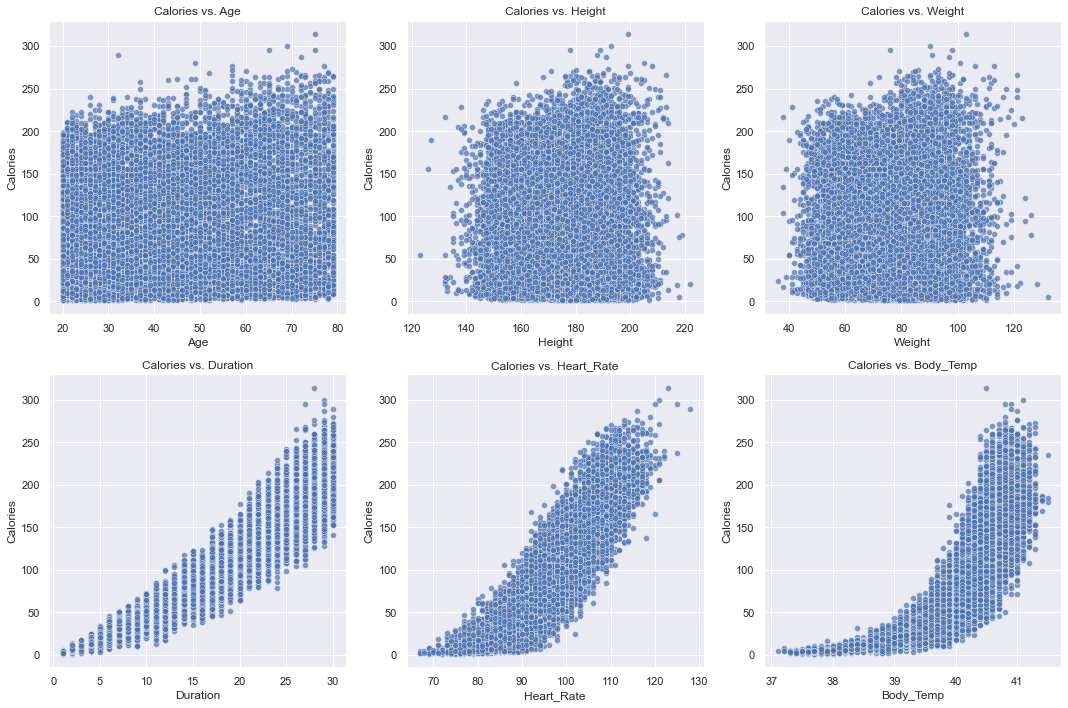

In [25]:
# Determine the number of rows and columns for subplots
num_columns = len(numerical_columns) - 1  # Exclude Calories as x-axis
num_rows = math.ceil(num_columns / 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Generate scatter plots for each numerical column against Calories
for idx, column in enumerate(numerical_columns):
    if column != 'Calories':  # Skip Calories as x-axis
        sns.scatterplot(x=df[column], y=df['Calories'], alpha=0.7, ax=axes[idx], edgecolor='w')
        axes[idx].set_title(f'Calories vs. {column}')
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Calories')

# Remove any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

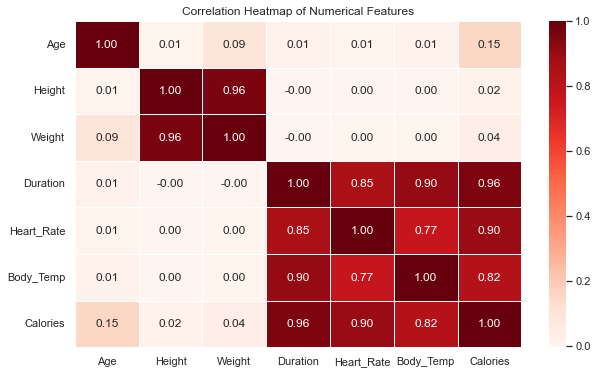

In [26]:
# Create a correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()  # Compute the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Consistent with intuitions, Duration and Heart_Rate show strong positive correlations with Calories, indicating that longer exercise sessions and higher heart rates result in more calories burned. Body_Temp also exhibits quite strong positive correlation, suggesting that higher body temperature increases calorie burn. 

### IV. Modeling and Evaluations

In [33]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['Calories'])
y = df['Calories']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=50, max_depth=10),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=50, max_depth=5, objective='reg:squarederror')
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "R2 Score": r2
    }

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                        MAE         MSE  R2 Score
Linear Regression  8.441514  131.995746  0.967294
Decision Tree      3.950771   33.480439  0.991704
Random Forest      2.302349   11.654624  0.997112
XGBoost            1.902184    6.692423  0.998342


**Linear Regression**
Performance: MAE of 8.44, MSE of 131.99, and R² Score of 0.967.
This model captures general trends well but struggles with nonlinear patterns, resulting in higher errors compared to the other models.

**Decision Tree**
Performance: MAE of 3.95, MSE of 33.48, and R² Score of 0.992.
Captures nonlinear relationships better than Linear Regression. However, it is prone to overfitting, which limits its generalization capability compared to ensemble models.

**Random Forest**
Performance: MAE of 2.30, MSE of 11.65, and R² Score of 0.997.
Demonstrates significant improvements in both accuracy and generalization. By averaging predictions from multiple decision trees, it effectively reduces overfitting while maintaining precision.

**XGBoost**
Performance: MAE of 1.90, MSE of 6.69, and R² Score of 0.998.
The best-performing model, with the lowest errors and the highest R² Score. XGBoost's gradient boosting framework allows it to learn complex patterns efficiently, outperforming all other models.

### V. Conclusion

- XGBoost is recommended for deployment due to its superior performance.
- Random Forest is a strong alternative, offering robust accuracy with slightly higher error margins, making it suitable for scenarios where simpler interpretability or faster training time is preferred.
- Linear Regression and Decision Tree models, while less effective, can still be useful for exploratory analysis or as baselines.